In [18]:
import copy
import time

import jax
import jax.numpy as jnp
from jax import jit, vmap, block_until_ready

import numpy as np
import matplotlib.pyplot as plt

from envs.single_photon_env import SinglePhotonLangevinReadoutEnv
from env_configs import get_sherbrooke_config

from rejax import get_algo

In [2]:
algo_str = "ppo"  # @param ["ppo", "dqn", "sac", "td3"]
env_str = "CartPole-v1"  # @param ["CartPole-v1", "Acrobot-v1", "Pendulum-v1"]

CONFIGS = {
    "sac": {"target_entropy_ratio": 0.7, "num_envs": 10, "gradient_steps": 5},
    "ppo": {"total_timesteps": 3e5},
    "dqn": {},
    "td3": {"total_timesteps": 5e4, "normalize_observations": True},
}
algo, config_cls = get_algo(algo_str)

In [3]:
s_config = get_sherbrooke_config()
s_config = copy.deepcopy(s_config)

env = SinglePhotonLangevinReadoutEnv(**s_config)

In [43]:
config = config_cls.create(
    env=env, 
    learning_rate=0.001,
    num_steps=1, # Single Step Environment
    num_envs=128, # Corresponds to Batchsize effectively
    total_timesteps=500,
    num_minibatches=4,
    eval_freq=100
)
config.replace(total_timesteps=50)

PPOConfig(env=<envs.single_photon_env.SinglePhotonLangevinReadoutEnv object at 0x7f8fef7cf160>, env_params=EnvParams(args=Array([7.155    , 1.9477874, 0.       ], dtype=float32), t1=0.63, ideal_photon=0.05, window_length=15, kernel=Array([0.06666667, 0.06666667, 0.06666667, 0.06666667, 0.06666667,
       0.06666667, 0.06666667, 0.06666667, 0.06666667, 0.06666667,
       0.06666667, 0.06666667, 0.06666667, 0.06666667, 0.06666667],      dtype=float64), gauss_mean=0.0, gauss_std=2.0, small_window=Array([-7., -6., -5., -4., -3., -2., -1.,  0.,  1.,  2.,  3.,  4.,  5.,
        6.,  7.], dtype=float64), gauss_kernel=Array([9.13472041e-12, 6.07588285e-09, 1.48671951e-06, 1.33830226e-04,
       4.43184841e-03, 5.39909665e-02, 2.41970725e-01, 3.98942280e-01,
       2.41970725e-01, 5.39909665e-02, 4.43184841e-03, 1.33830226e-04,
       1.48671951e-06, 6.07588285e-09, 9.13472041e-12], dtype=float64), dirac_delta_kernel=Array([1.], dtype=float64), photon_penalty=50.0, bandwidth_penalty=5.0, smooth

In [44]:
config.__dict__

{'env': <envs.single_photon_env.SinglePhotonLangevinReadoutEnv at 0x7f8fef7cf160>,
 'env_params': EnvParams(args=Array([7.155    , 1.9477874, 0.       ], dtype=float32), t1=0.63, ideal_photon=0.05, window_length=15, kernel=Array([0.06666667, 0.06666667, 0.06666667, 0.06666667, 0.06666667,
        0.06666667, 0.06666667, 0.06666667, 0.06666667, 0.06666667,
        0.06666667, 0.06666667, 0.06666667, 0.06666667, 0.06666667],      dtype=float64), gauss_mean=0.0, gauss_std=2.0, small_window=Array([-7., -6., -5., -4., -3., -2., -1.,  0.,  1.,  2.,  3.,  4.,  5.,
         6.,  7.], dtype=float64), gauss_kernel=Array([9.13472041e-12, 6.07588285e-09, 1.48671951e-06, 1.33830226e-04,
        4.43184841e-03, 5.39909665e-02, 2.41970725e-01, 3.98942280e-01,
        2.41970725e-01, 5.39909665e-02, 4.43184841e-03, 1.33830226e-04,
        1.48671951e-06, 6.07588285e-09, 9.13472041e-12], dtype=float64), dirac_delta_kernel=Array([1.], dtype=float64), photon_penalty=50.0, bandwidth_penalty=5.0, smoothnes

In [45]:
rng = jax.random.PRNGKey(0)
train_fn = jax.jit(algo.train)

In [46]:
print("Starting to train")

# Train!
start = time.time()
train_state, evaluation = train_fn(config, rng)
time_elapsed = time.time() - start

sps = config.total_timesteps / time_elapsed
print(f"Finished training in {time_elapsed:g} seconds ({sps:g} steps/second).")

Starting to train
Finished training in 38.7411 seconds (12.9062 steps/second).


[-202.5097157  -200.84811793 -210.53135089 -201.70995462 -198.30945987
 -194.27146315]


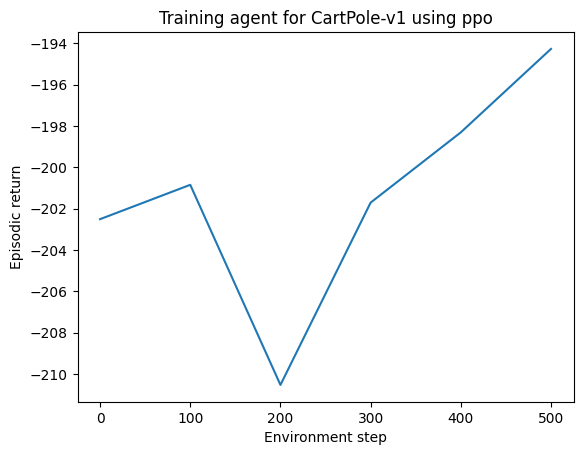

In [47]:
from matplotlib import pyplot as plt

episode_lengths, episode_returns = evaluation
mean_return = episode_returns.mean(axis=1)
print(mean_return)

plt.plot(jax.numpy.linspace(0, config.total_timesteps, len(mean_return)), mean_return)
plt.xlabel("Environment step")
plt.ylabel("Episodic return")
plt.title(f"Training agent for {env_str} using {algo_str}")
plt.show()